In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('corpus.csv')
df

,Unnamed: 0,artist,title,year,album,lyrics,n_words,pageviews,contributors,url
0,1,Dry,94310,2012.0,Tôt ou tard,"[Paroles de ""94310"" ft. Madj, Larso & Stokas]\...",748,0,8,https://genius.com/Dry-94310-lyrics
1,2,Mafia K’1 Fry,Au bon vieux temps,2007.0,Jusqu’à la mort,"\nEt je les entends tous les Zoulous, ils parl...",958,7514,8,https://genius.com/Mafia-k1-fry-au-bon-vieux-t...
2,3,DJ Hamida,Attrape-Moi Si Tu Peux,NaN,Mix Party 2015,[Refrain : Charly Bell]\nOui je sais qu’t’as e...,367,0,4,https://genius.com/Dj-hamida-attrape-moi-si-tu...
3,4,Kery James,94 c’est le Barça Remix,NaN,NaN,"\nC'est pour les rudeboys, c'est pour les cail...",535,0,7,https://genius.com/Kery-james-94-cest-le-barca...
4,5,Dry,14 ans déjà,2013.0,Maintenant ou jamais,"[Paroles de ""14 ans déjà""]\n\n\nTu sais, j'cro...",653,5037,8,https://genius.com/Dry-14-ans-deja-lyrics
...,...,...,...,...,...,...,...,...,...,...
85018,85019,Bricksy & 3g,Akai,2024.0,But It Ain’t,"[Paroles de ""Akai"" ft. La Fève]\n\n\nFF7\nWalo...",471,0,7,https://genius.com/Bricksy-and-3g-akai-lyrics
85019,85020,Bricksy & 3g,I am GIA,2024.0,But It Ain’t,"[Paroles de ""I am GIA""]\n\n\nSa star\nIl me di...",522,0,4,https://genius.com/Bricksy-and-3g-i-am-gia-lyrics
85020,85021,Rafal,ROMEO,2024.0,NaN,\n\n\nPrépare le sparadrap\nJ'péterais ma tête...,393,0,4,https://genius.com/Rafal-romeo-lyrics
85021,85022,Aktéfräzé,"Alpha, kilo, tango, [é]cho... Triple comme au ...",1999.0,B.O.S.S. Vol. 1,\nComme au scrabble et...\n\n\nLa fine fleur d...,464,0,1,https://genius.com/Aktefraze-alpha-kilo-tango-...


# Sexism analysis

Huggingface model :  https://huggingface.co/annahaz/xlm-roberta-base-misogyny-sexism-indomain-mix-bal

In [11]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("annahaz/xlm-roberta-base-misogyny-sexism-indomain-mix-bal")
model = AutoModelForSequenceClassification.from_pretrained("annahaz/xlm-roberta-base-misogyny-sexism-indomain-mix-bal")

c:\miniconda\envs\env_1\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [12]:
# text = 'Ceci est une phrase neutre'
# text = 'Bonjour, je vous trouve très jolie'
text = 'T\'es bonne ouech'
# text = 'Chez moi, que de la bonne substance, normal elle sort d\'Amsterdam'
# text = 'C\'est une salope'
# text = 'Je vais te la mettre si t\'ouvres tes fesses'


inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

print(logits)

predicted_class_id = logits.argmax().item()
# model.config.id2label[predicted_class_id]
predicted_class_id

tensor([[ 2.7519, -3.4935]])


0

In [110]:
import re

def clean_text(text):
    # text = text.replace('\n', ' ')
    # text = text.replace('\r', ' ')
    text = re.sub(r'\[.*?\]', '', text) # remove text between brackets (title)
    text = re.sub(r'[^\w\s]', ' ', text) # remove punctuation
    return text

def violence_probability(line):
    inputs = tokenizer(line, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    # predicted_class_id = logits.argmax().item()
    # return model.config.id2label[predicted_class_id]
    return logits

def categorize(lyrics):
    # for each line of the lyrics, get the probability of violence and return the mean
    if type(lyrics) != str:
        return None
    lyrics = clean_text(lyrics)
    lines = lyrics.split('\n')
    lines = [line for line in lines if line] # remove empty lines
    if len(lines) == 0:
        return None
    # print(lines)
    probabilities = [violence_probability(line) for line in lines]
    # print(probabilities)

    # mean_probability = sum(probabilities) / len(probabilities)
    # mean_probability = mean_probability.numpy()
    # print('mean probability : ', mean_probability)    
    # predicted_class_id = mean_probability.argmax().item()
    # mean_proba_classe = model.config.id2label[predicted_class_id]

    # get the class of each line
    classes = [model.config.id2label[proba.argmax().item()] for proba in probabilities]
    # print(classes)
    nb_violent_lines = len([cl for cl in classes if cl == '1'])
    nb_non_violent_lines = len([cl for cl in classes if cl == '0'])
    ratio_violent_lines = nb_violent_lines / (nb_violent_lines + nb_non_violent_lines)
    # print('ratio violent lines : ', ratio_violent_lines)

    # return mean_probability, ratio_violent_lines
    return ratio_violent_lines

lyrics = df['lyrics'][0]
categorize(lyrics)

0.21875

In [6]:
df_alkpote = df[df['artist'] == 'Alkpote']
for i in range(10):
    lyrics = df_alkpote.iloc[i]['lyrics']
    # print('lyrics : ', lyrics)
    print(categorize(lyrics))
    # print('\n\n\n\n')

(tensor([[-0.1422, -0.0194]]), 0.5888888888888889)
(tensor([[ 0.8407, -1.2274]]), 0.43283582089552236)
(tensor([[ 1.1938, -1.5892]]), 0.25)
(tensor([[ 1.5284, -1.9794]]), 0.24528301886792453)
(tensor([[ 1.2478, -1.6807]]), 0.28735632183908044)
(tensor([[ 1.5624, -2.0617]]), 0.18556701030927836)
(tensor([[ 0.5954, -0.9085]]), 0.4074074074074074)
(tensor([[ 1.1115, -1.5045]]), 0.2807017543859649)
(tensor([[-0.6203,  0.5877]]), 0.6111111111111112)
(tensor([[ 1.7283, -2.2697]]), 0.16666666666666666)


# Sexism per artist

In [138]:
most_popular_artists = df[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(35)
df[df['artist'].isin(most_popular_artists.index)]

,Unnamed: 0,artist,title,year,album,lyrics,n_words,pageviews,contributors,url
3,4,Kery James,94 c’est le Barça Remix,<NA>,NaN,"\nC'est pour les rudeboys, c'est pour les cail...",535,0,7,https://genius.com/Kery-james-94-cest-le-barca...
7,8,Sexion d’Assaut,Assez,2012,L’Apogée,"[Paroles de ""Assez"" ft. Dry]\n\n[Refrain : Maî...",676,42418,20,https://genius.com/Sexion-dassaut-assez-lyrics
10,11,Kalash,SO COMAN,2024,NaN,"\nYo\nBad gyal, bad boy\n2024 nou pa'a débat é...",437,0,6,https://genius.com/Kalash-so-coman-lyrics
45,46,Ninho,3 MAI 2025,2024,NaN,"[Paroles de ""3 MAI 2025""]\n\n\nHey\nBLN\nC'est...",344,7067,9,https://genius.com/Ninho-3-mai-2025-lyrics
50,51,Kery James,En feu de détresse,<NA>,Ma vérité,\nMes fautes sont lourdes car mes défauts sont...,653,13241,8,https://genius.com/Kery-james-en-feu-de-detres...
...,...,...,...,...,...,...,...,...,...,...
84826,84827,GIMS,CYPHER,2024,LES DERNIÈRES VOLONTÉS DE MOZART (SYMPHONY),[Paroles issu d'un extrait Instagram]\n\n\n\nT...,235,0,4,https://genius.com/Gims-cypher-lyrics
84862,84863,GIMS,Bériz,2023,NaN,"\n\n\nJ'suis sur Bériz, plié comme dans l'dern...",206,0,1,https://genius.com/Gims-beriz-lyrics
84965,84966,Rohff,Dis Mon Nom,2005,Au-delà de mes limites,"\nY'a pas que les têtes qu'on piétine, y'a l'a...",681,5451,10,https://genius.com/Rohff-dis-mon-nom-lyrics
84978,84979,Rohff,Catastrohff,<NA>,Le code de l’honneur,"\nDémarrage hold-up, meilleur pilote que David...",1003,0,15,https://genius.com/Rohff-catastrohff-lyrics


In [139]:
# get 10 most popular artists (by number of pageviews on total on genius)
most_popular_artists = df[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(35)
dict_sexism_per_artist = {}
# apply categorize function to each artist
for artist in most_popular_artists.index:
    print('artist : ', artist)
    df_artist = df[df['artist'] == artist]
    # keep the 10 most popular songs of the artist
    df_artist = df_artist.sort_values(by='pageviews', ascending=False).head(50)
    sexism_index = []
    for i in range(len(df_artist)):
        # print('song : ', i)
        lyrics = df_artist.iloc[i]['lyrics']
        # print('lyrics : ', lyrics)
        # print(f'song {i}: ', categorize(lyrics))
        # print('\n\n\n\n')
        sexism_index.append(categorize(lyrics))
    print('mean sexism index : ', sum(sexism_index) / len(sexism_index))
    dict_sexism_per_artist[artist] = sum(sexism_index) / len(sexism_index)
print(dict_sexism_per_artist)

with open('sexism_per_artist.json', 'w') as f:
    json.dump(dict_sexism_per_artist, f)


artist :  Booba
mean sexism index :  0.257170327571141
artist :  PNL
mean sexism index :  0.26351553659396343
artist :  Nekfeu
mean sexism index :  0.19741556978637792
artist :  JuL
mean sexism index :  0.25273628374073737
artist :  Damso
mean sexism index :  0.22336866464022925
artist :  Stromae
mean sexism index :  0.1565392796540128
artist :  Lacrim
mean sexism index :  0.24765847217841816
artist :  SCH
mean sexism index :  0.29686305476982033
artist :  GIMS
mean sexism index :  0.18208886791723733
artist :  Ninho
mean sexism index :  0.2579591031593867
artist :  Vald
mean sexism index :  0.2617200794741192
artist :  Kaaris
mean sexism index :  0.3189471328581595
artist :  OrelSan
mean sexism index :  0.1653271685195906
artist :  Freeze Corleone
mean sexism index :  0.15022901209991765
artist :  Niro
mean sexism index :  0.2792039755547399
artist :  La Fouine
mean sexism index :  0.26997442667326504
artist :  Rohff
mean sexism index :  0.2625227957155266
artist :  Niska
mean sexism 

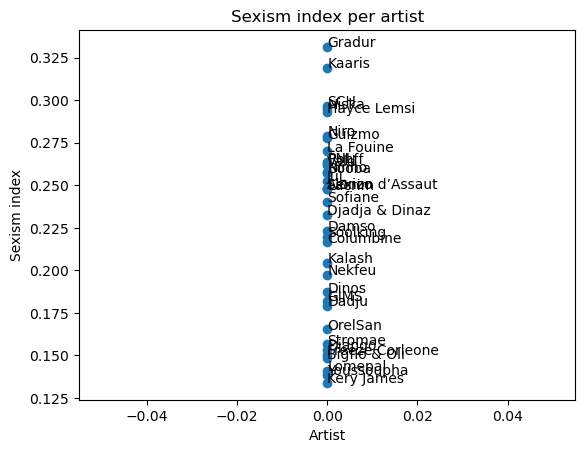

In [141]:
def plot_sexism_per_artist():
    with open('LLM/sexism_per_artist.json', 'r') as f:
        dict_sexism_per_artist = json.load(f)
    plt.scatter([0] * len(dict_sexism_per_artist), dict_sexism_per_artist.values())
    for i in range(len(dict_sexism_per_artist)):
        plt.text(0, list(dict_sexism_per_artist.values())[i], list(dict_sexism_per_artist.keys())[i])
    plt.title('Sexism index per artist')
    plt.xlabel('Artist')
    plt.ylabel('Sexism index')

plot_sexism_per_artist()

# Temporal analysis

In [ ]:
df[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(10).index


Index(['Booba', 'PNL', 'Nekfeu', 'JuL', 'Damso', 'Stromae', 'Lacrim', 'SCH',
       'GIMS', 'Ninho'],
      dtype='object', name='artist')

In [47]:
df_clean = df[df['year']>= 1995]
sexism_total = {}
for year in range(1995, 2025):
    print('year : ', year)
    df_current_year = df_clean[df_clean['year'] == year]
    sexism_index_year = {}
    # keep only artist that were in the top 10 most popular artists of the year
    most_popular_artists = df_current_year[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(5).index
    for artist in most_popular_artists:
        print('artist : ', artist)
        df_current_artist = df_current_year[df_current_year['artist'] == artist]
        # keep the 10 most popular songs of the year for this artist
        df_current_artist = df_current_artist.sort_values(by='pageviews', ascending=False).head(10)
        if df_current_artist.shape[0] == 0:
            sexism_index_year[artist] = None
        else:
            sexism_index = []
            for i in range(len(df_current_artist)):
                lyrics = df_current_artist.iloc[i]['lyrics']
                sexism_index.append(categorize(lyrics))
            print('mean sexism index : ', sum(sexism_index) / len(sexism_index))
            sexism_index_year[artist] = sum(sexism_index) / len(sexism_index)
    print('sexism index year : ', sexism_index_year)
    sexism_total[year] = sexism_index_year

print("\n\n\n", sexism_total)   

year :  1995
artist :  Akhenaton
mean sexism index :  0.17122087265881908
artist :  Suprême NTM
mean sexism index :  0.10130338774211105
artist :  Ministère A.M.E.R.
mean sexism index :  0.07352941176470588
artist :  Lunatic
mean sexism index :  0.28403499817680544
artist :  Les Sages Poètes de la Rue
mean sexism index :  0.18596525747173803
sexism index year :  {'Akhenaton': 0.17122087265881908, 'Suprême NTM': 0.10130338774211105, 'Ministère A.M.E.R.': 0.07352941176470588, 'Lunatic': 0.28403499817680544, 'Les Sages Poètes de la Rue': 0.18596525747173803}
year :  1996
artist :  Doc Gynéco
mean sexism index :  0.21722747375732449
artist :  Lunatic
mean sexism index :  0.24042709867452136
artist :  Ideal J
mean sexism index :  0.2051718786367096
artist :  La Clinique
mean sexism index :  0.38202247191011235
artist :  Time Bomb (FRA)
mean sexism index :  0.23333333333333334
sexism index year :  {'Doc Gynéco': 0.21722747375732449, 'Lunatic': 0.24042709867452136, 'Ideal J': 0.20517187863670

In [48]:
# save the dict in a csv file
import csv

with open('sexism_total.csv', 'w') as f:
    for key in sexism_total.keys():
        f.write("%s,%s\n"%(key,sexism_total[key]))

In [73]:
df_clean = df[df['year']>= 1995]
sexism_total = {}
for year in range(1995, 2025):
    print('year : ', year)
    df_current_year = df_clean[df_clean['year'] == year]
    sexism_index_year = {}
    # keep the 50 most popular songs of this year
    df_current_year = df_current_year.sort_values(by='pageviews', ascending=False).head(50)
    sexism_index = []
    for i in range(len(df_current_year)):
        lyrics = df_current_year.iloc[i]['lyrics']
        # print(lyrics)
        sexism_index.append(categorize(lyrics))
    # print(sexism_index)
    sexism_index = [index for index in sexism_index if index is not None]
    mean_sexism_index = sum(sexism_index) / len(sexism_index)
    print('mean sexism index : ', mean_sexism_index)
    sexism_total[year] = mean_sexism_index

print("\n\n\n", sexism_total) 


with open('mean_sexism_per_year_50songs.json', 'w') as f:
    json.dump(sexism_total, f)


year :  1995
mean sexism index :  0.157270502472126
year :  1996
mean sexism index :  0.20775338986944483
year :  1997
mean sexism index :  0.18459425675874577
year :  1998
mean sexism index :  0.20753606660347684
year :  1999
mean sexism index :  0.17698456904143217
year :  2000
mean sexism index :  0.18121294330807716
year :  2001
mean sexism index :  0.18798744878666124
year :  2002
mean sexism index :  0.23583155264417463
year :  2003
mean sexism index :  0.1953705553114953
year :  2004
mean sexism index :  0.24128003738092763
year :  2005
mean sexism index :  0.21828191878866882
year :  2006
mean sexism index :  0.22166368490732136
year :  2007
mean sexism index :  0.2301023910959503
year :  2008
mean sexism index :  0.21734137626242817
year :  2009
mean sexism index :  0.206668195434192
year :  2010
mean sexism index :  0.23150796962541814
year :  2011
mean sexism index :  0.2485546008339713
year :  2012
mean sexism index :  0.23545328766406218
year :  2013
mean sexism index :  0

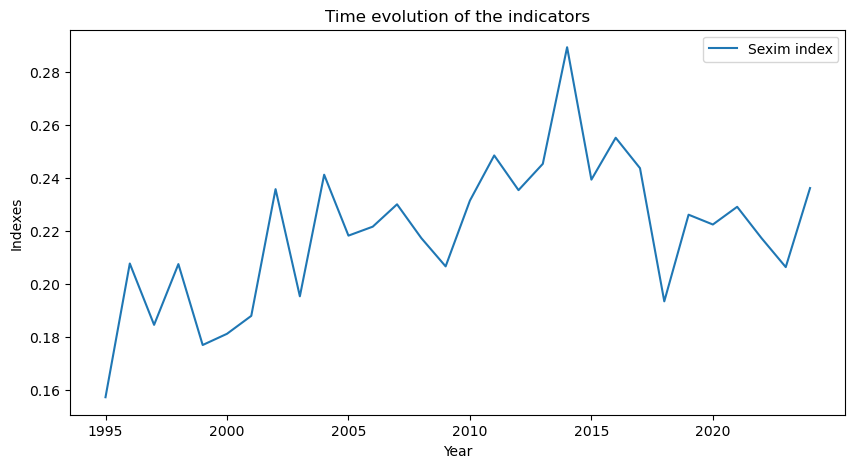

In [89]:
import numpy as np


def plot_sexism_per_year():
    # get the file from json
    with open('mean_sexism_per_year_50songs.json', 'r') as f:
        sexism_total = json.load(f)
    plt.figure(figsize=(10, 5))
    plt.plot(list(sexism_total.keys()), list(sexism_total.values()), label = 'Sexim index')
    plt.legend()
    plt.title('Time evolution of the indicators')
    plt.xlabel('Year')
    plt.ylabel('Indexes')
    # show a tick every 5 years
    plt.xticks(np.arange(0, len(sexism_total), 5), np.arange(1995, 2025, 5))
    # plt.xticks(np.arange(1995, 2025, 1))
    plt.show()

plot_sexism_per_year()

# Evolution of sexism for top artists

In [113]:
most_popular_artists = df[['artist', 'pageviews']].groupby('artist').sum().sort_values(by='pageviews', ascending=False).head(10).index

dict_sexism_per_artist = {}
for artist in most_popular_artists:
    print('artist : ', artist)
    df_artist = df[df['artist'] == artist]
    dict_sexism_per_year = {}
    for year in range(1995, 2025):
        print('year', year)
        df_artist_year = df_artist[df_artist['year'] == year]
        # keep 20 most popular songs of the artist for this year
        df_artist_year = df_artist_year.sort_values(by='pageviews', ascending=False).head(20)
        if df_artist_year.shape[0] == 0:
            dict_sexism_per_year[year] = None
            continue
        sexism_index = []
        for i in range(len(df_artist_year)):
            lyrics = df_artist_year.iloc[i]['lyrics']
            index = categorize(lyrics)
            if index is not None:
                sexism_index.append(index)
        mean_sexism_index = sum(sexism_index) / len(sexism_index)
        dict_sexism_per_year[year] = mean_sexism_index
    dict_sexism_per_artist[artist] = dict_sexism_per_year

# save json
with open('dict_sexism_per_artist.json', 'w') as f:
    json.dump(dict_sexism_per_artist, f)

artist :  Booba
year 1995
year 1996
year 1997
year 1998
year 1999
year 2000
year 2001
year 2002
year 2003
year 2004
year 2005
year 2006
year 2007
year 2008
year 2009
year 2010
year 2011
year 2012
year 2013
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
year 2021
year 2022
year 2023
year 2024
artist :  PNL
year 1995
year 1996
year 1997
year 1998
year 1999
year 2000
year 2001
year 2002
year 2003
year 2004
year 2005
year 2006
year 2007
year 2008
year 2009
year 2010
year 2011
year 2012
year 2013
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
year 2021
year 2022
year 2023
year 2024
artist :  Nekfeu
year 1995
year 1996
year 1997
year 1998
year 1999
year 2000
year 2001
year 2002
year 2003
year 2004
year 2005
year 2006
year 2007
year 2008
year 2009
year 2010
year 2011
year 2012
year 2013
year 2014
year 2015
year 2016
year 2017
year 2018
year 2019
year 2020
year 2021
year 2022
year 2023
year 2024
artist :  JuL
year 1995
year 1996
year 1997
year 1998

In [114]:
dict_sexism_per_artist

{'Booba': {1995: None,
  1996: None,
  1997: None,
  1998: None,
  1999: None,
  2000: None,
  2001: 0.21568627450980393,
  2002: 0.24564305795715713,
  2003: 0.3141811211664153,
  2004: 0.2601508219204943,
  2005: 0.250524656747247,
  2006: 0.24635615803525898,
  2007: 0.25651375172616697,
  2008: 0.2435685786876263,
  2009: 0.22259449244592688,
  2010: 0.21137262142847163,
  2011: 0.22383285122805288,
  2012: 0.23659950517387848,
  2013: 0.20850471677001725,
  2014: 0.28250745156482865,
  2015: 0.2357382579429311,
  2016: 0.3589921516392105,
  2017: 0.3040092868950181,
  2018: 0.1886904761904762,
  2019: 0.1090686274509804,
  2020: 0.1702059202059202,
  2021: 0.21023381673327027,
  2022: 0.12369505494505495,
  2023: 0.10896057347670252,
  2024: 0.18031711905267747},
 'PNL': {1995: None,
  1996: None,
  1997: None,
  1998: None,
  1999: None,
  2000: None,
  2001: None,
  2002: None,
  2003: None,
  2004: None,
  2005: None,
  2006: None,
  2007: None,
  2008: None,
  2009: None,
  20

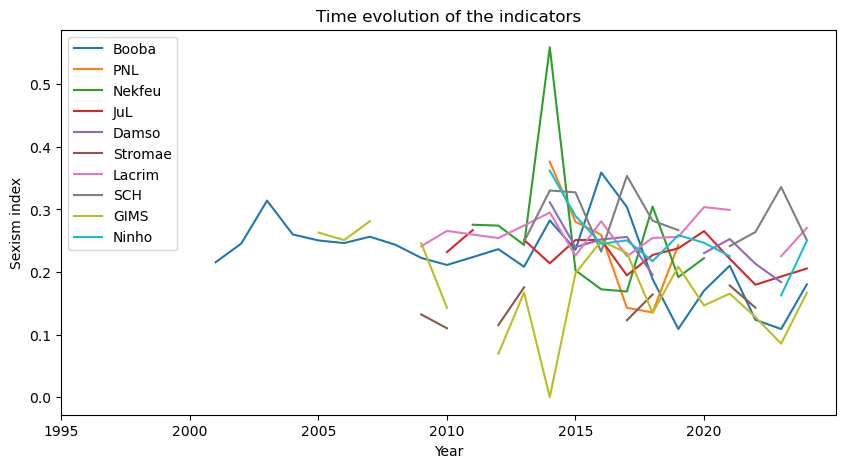

In [ ]:
def plot_sexism_evolution_per_artist():
    with open('dict_sexism_per_artist.json', 'r') as f:
        dict_sexism_per_artist = json.load(f)
        plt.figure(figsize=(10, 5))
        for artist, dict_sexism_per_year in dict_sexism_per_artist.items():
            plt.plot(list(dict_sexism_per_year.keys()), list(dict_sexism_per_year.values()), label = artist)
        plt.legend()
        plt.title('Time evolution of the sexism for the 10 most popular artists')
        plt.xlabel('Year')
        plt.ylabel('Sexism index')
        plt.xticks(np.arange(0, len(sexism_total), 5), np.arange(1995, 2025, 5))
        plt.show()

plot_sexism_evolution_per_artist()

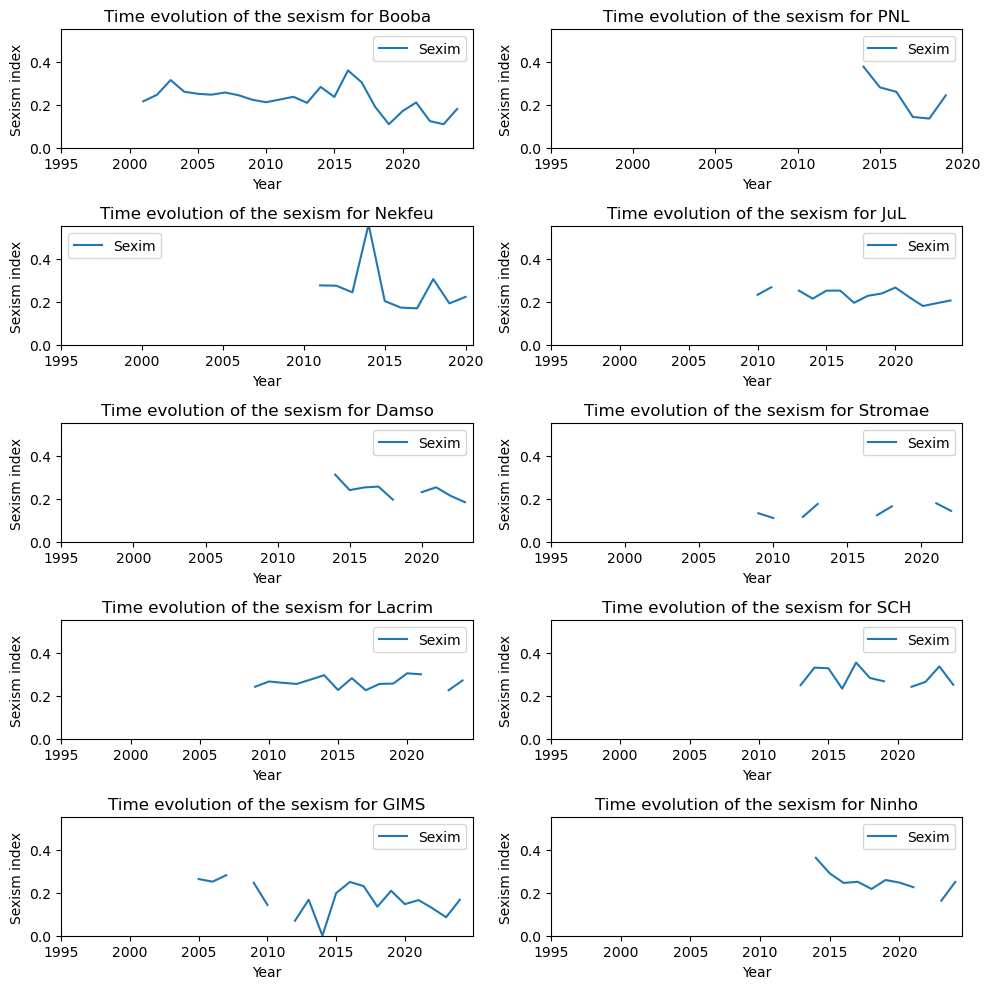

In [127]:
def plot_sexism_evolution_per_artist():
    with open('dict_sexism_per_artist.json', 'r') as f:
        dict_sexism_per_artist = json.load(f)
    plt.figure(figsize=(10, 10))
    for i, (artist, dict_sexism_per_year) in enumerate(dict_sexism_per_artist.items()):
        plt.subplot(5, 2, i+1)
        plt.plot(list(dict_sexism_per_year.keys()), list(dict_sexism_per_year.values()), label = 'Sexim')
        plt.legend()
        plt.title(f'Time evolution of the sexism for {artist}')
        plt.xlabel('Year')
        plt.ylabel('Sexism index')
        plt.ylim(0, 0.55)
        plt.xticks(np.arange(0, len(sexism_total), 5), np.arange(1995, 2025, 5))
    plt.tight_layout()
    plt.show()

plot_sexism_evolution_per_artist()

# Plots presentation

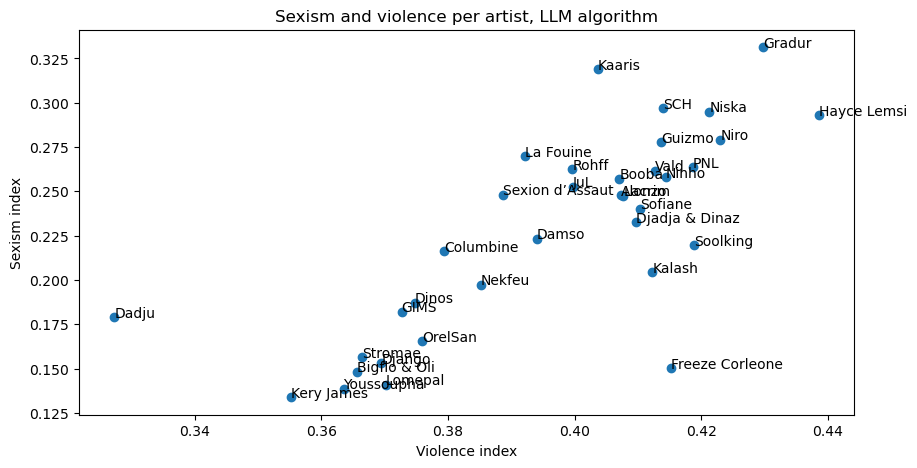

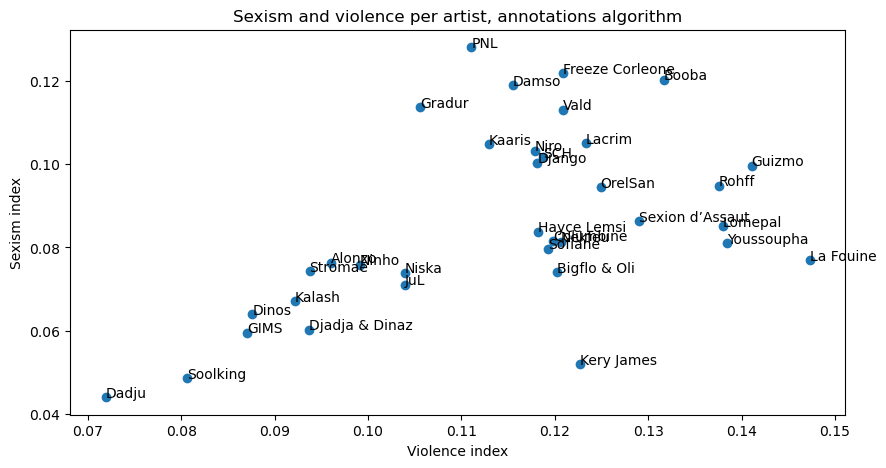

In [ ]:
def plot_indexes_per_artist(algo):
    with open(f'{algo}/sexism_per_artist.json', 'r') as f:
        sexism_per_artist = json.load(f)
    with open(f'{algo}/violence_per_artist.json', 'r') as f:
        violence_per_artist = json.load(f)
    plt.figure(figsize=(10, 5))
    plt.scatter(list(violence_per_artist.values()), list(sexism_per_artist.values()))
    for i in range(len(sexism_per_artist)):
        plt.text(list(violence_per_artist.values())[i], list(sexism_per_artist.values())[i], list(sexism_per_artist.keys())[i])
    plt.title(f'Sexism and violence per artist, {algo} algorithm')
    plt.xlabel('Violence index')
    plt.ylabel('Sexism index')
    plt.show()

plot_indexes_per_artist(algo='LLM')
plot_indexes_per_artist(algo='annotations')

<Figure size 1000x500 with 0 Axes>

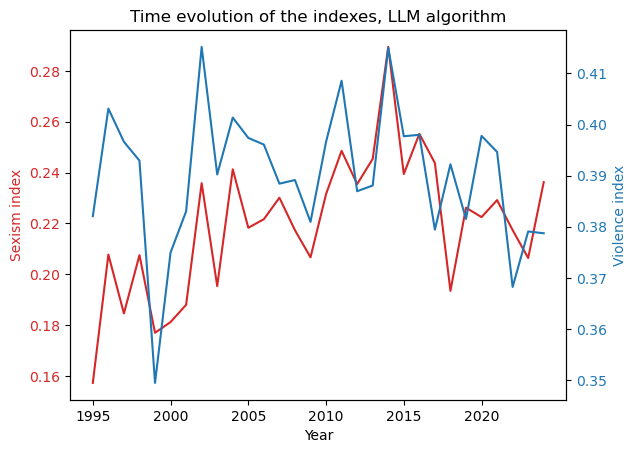

<Figure size 1000x500 with 0 Axes>

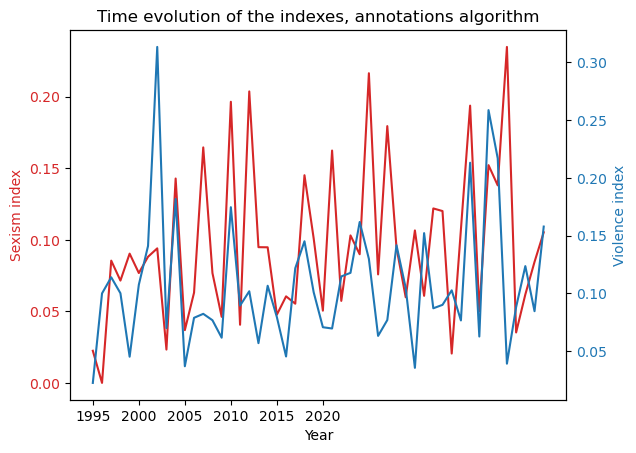

In [159]:
def plot_indexes_per_year(algo):
    # get the file from json
    with open(f'{algo}/mean_sexism_per_year.json', 'r') as f:
        sexism_per_year = json.load(f)
    with open(f'{algo}/mean_violence_per_year.json', 'r') as f:
        violence_per_year = json.load(f)
    plt.figure(figsize=(10, 5))
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Sexism index', color=color)
    ax1.plot(list(sexism_per_year.keys()), list(sexism_per_year.values()), color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Violence index', color=color)
    ax2.plot(list(violence_per_year.keys()), list(violence_per_year.values()), color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.title(f'Time evolution of the indexes, {algo} algorithm')
    plt.xlabel('Year')
    plt.xticks(np.arange(0, len(sexism_total), 5), np.arange(1995, 2025, 5))
    plt.show()

plot_indexes_per_year(algo='LLM')
plot_indexes_per_year(algo='annotations')

In [167]:
with open(f'LLM/sexism_per_artist_per_year.json', 'r') as f:
    sexism_per_artist_per_year = json.load(f)
sexism_per_artist_per_year

{'Booba': {'1995': None,
  '1996': None,
  '1997': None,
  '1998': None,
  '1999': None,
  '2000': None,
  '2001': 0.21568627450980393,
  '2002': 0.24564305795715713,
  '2003': 0.3141811211664153,
  '2004': 0.2601508219204943,
  '2005': 0.250524656747247,
  '2006': 0.24635615803525898,
  '2007': 0.25651375172616697,
  '2008': 0.2435685786876263,
  '2009': 0.22259449244592688,
  '2010': 0.21137262142847163,
  '2011': 0.22383285122805288,
  '2012': 0.23659950517387848,
  '2013': 0.20850471677001725,
  '2014': 0.28250745156482865,
  '2015': 0.2357382579429311,
  '2016': 0.3589921516392105,
  '2017': 0.3040092868950181,
  '2018': 0.1886904761904762,
  '2019': 0.1090686274509804,
  '2020': 0.1702059202059202,
  '2021': 0.21023381673327027,
  '2022': 0.12369505494505495,
  '2023': 0.10896057347670252,
  '2024': 0.18031711905267747},
 'PNL': {'1995': None,
  '1996': None,
  '1997': None,
  '1998': None,
  '1999': None,
  '2000': None,
  '2001': None,
  '2002': None,
  '2003': None,
  '2004': 

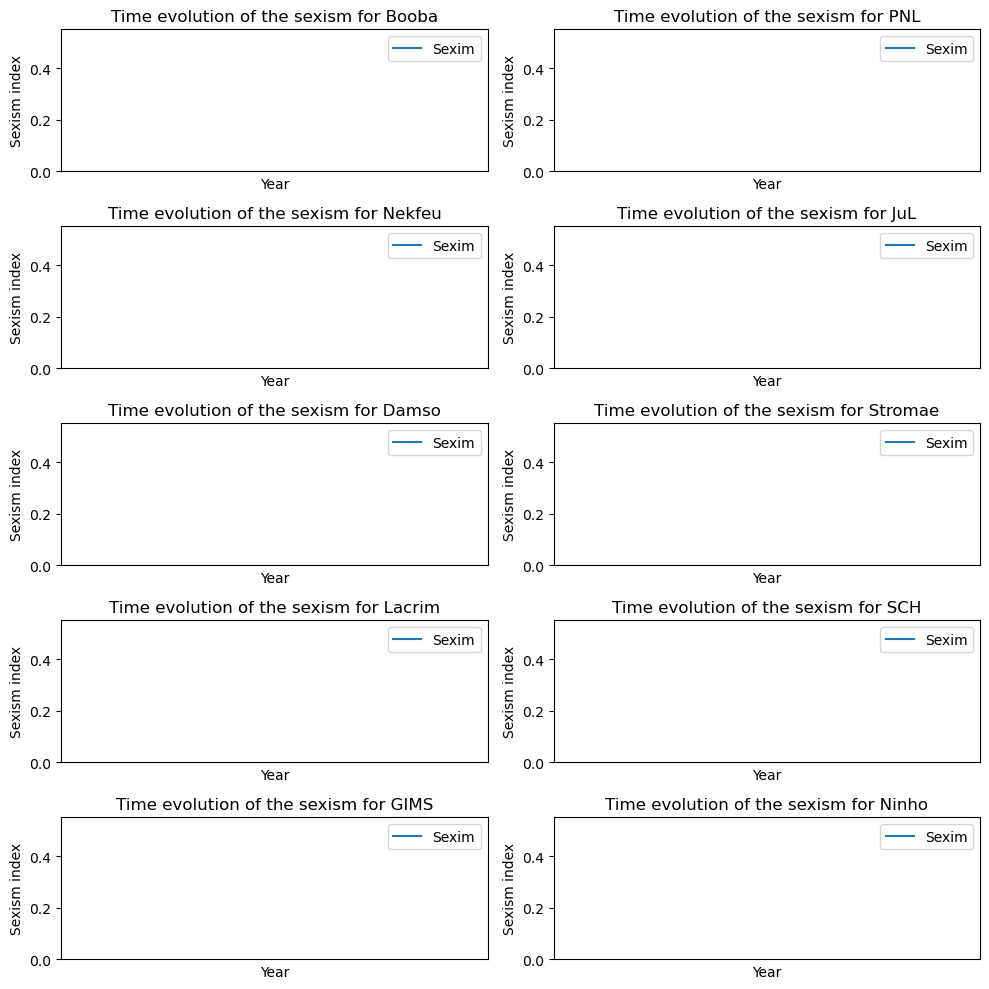

ValueError: num must be an integer with 1 <= num <= 10, not 11

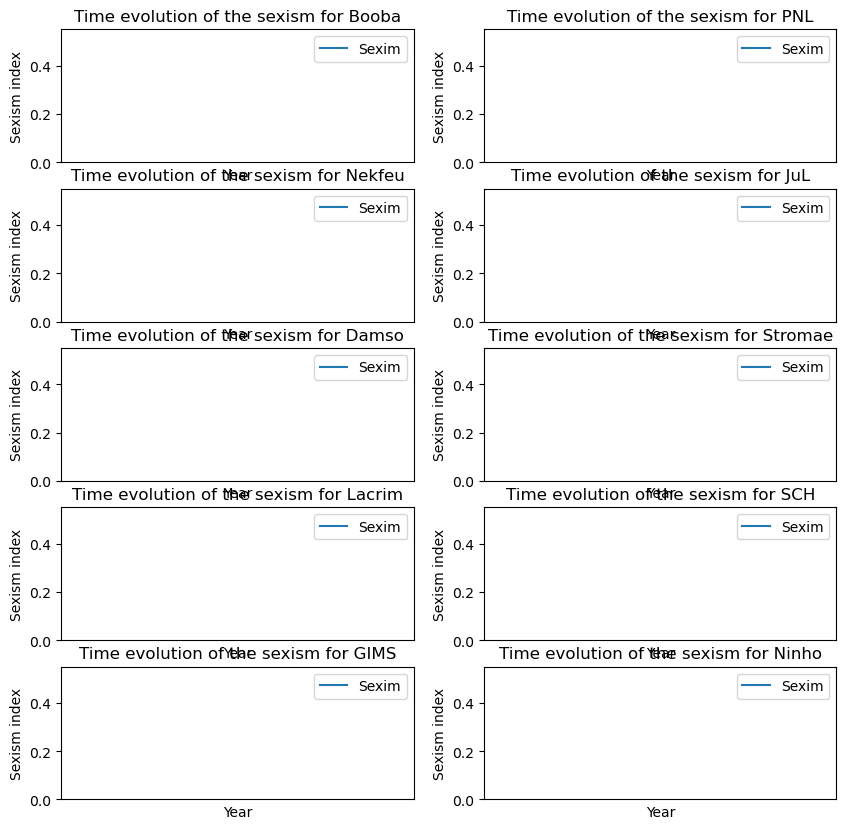

In [ ]:
def plot_indexes_evolution_per_artist(algo):
    with open(f'{algo}/sexism_per_artist_per_year.json', 'r') as f:
        sexism_per_artist_per_year = json.load(f)
    with open(f'{algo}/violence_per_artist_per_year.json', 'r') as f:
        violence_per_artist_per_year = json.load(f)
    plt.figure(figsize=(10, 10))
    for i, (artist, sexism_per_year) in enumerate(sexism_per_artist_per_year.items()):
        plt.subplot(5, 2, i+1)
        plt.plot(list(sexism_per_year.keys()), list(sexism_per_year.values()), label = 'Sexim')
        plt.legend()
        plt.title(f'Time evolution of the sexism for {artist}')
        plt.xlabel('Year')
        plt.ylabel('Sexism index')
        plt.ylim(0, 0.55)

        # plt.xticks(np.arange(0, 35, 5), np.arange(1995, 2025, 5))
    plt.tight_layout()
    plt.show()

plot_indexes_evolution_per_artist(algo='LLM')
plot_indexes_evolution_per_artist(algo='annotations')